In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] a= 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False


# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

In [2]:
df = pd.read_csv('data/merged_data_brand_dropna.csv')

In [3]:
# 1. event_time_moscow을 datetime으로 변환
df['event_time'] = pd.to_datetime(df['event_time_moscow'], errors='coerce')

# 2. 날짜 단위 추출 (datetime 유지)
df['event_date'] = df['event_time'].dt.floor('D')

# 3. 유저별 첫 방문일 계산
first_visit = df.groupby('user_id')['event_date'].min().reset_index()
first_visit.columns = ['user_id', 'first_date']

In [4]:
# 4. 원본 df와 병합
df = df.merge(first_visit, on='user_id', how='left')

# 5. N일차 계산
df['days_since_first'] = (df['event_date'] - df['first_date']).dt.days

In [5]:
# 6. 중복 제거 (user_id가 특정 day에 방문했는지만 체크)
retention_log = df[['user_id', 'days_since_first']].drop_duplicates()

# 7. 일자별 잔존 유저 수 계산
retention_counts = retention_log.groupby('days_since_first')['user_id'].nunique()

In [6]:
# 8. Day 0 유저 수
day0_users = retention_counts.loc[0]

# 9. 리텐션율 계산 (%)
retention_rate = (retention_counts / day0_users * 100).round(2)

days_since_first
0    100.00
1      6.52
2      3.18
3      2.44
4      2.05
5      1.82
6      1.70
7      1.62
8      1.42
9      1.25
Name: user_id, dtype: float64


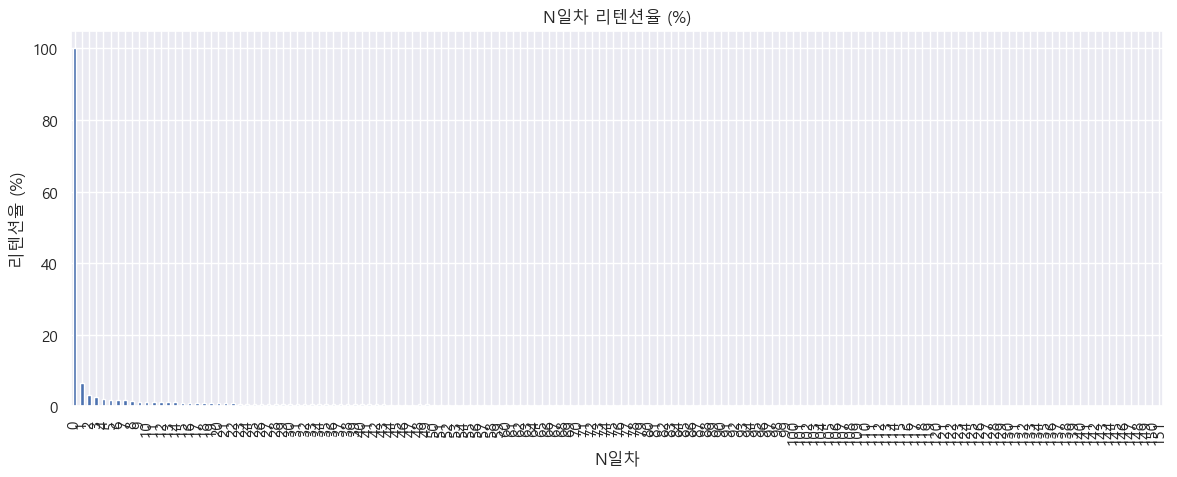

In [7]:
# 10. 출력
print(retention_rate.head(10))  # N일차 리텐션율 상위 15개

# 11. 시각화 (선택)
retention_rate.plot(kind='bar', figsize=(12, 5), title='N일차 리텐션율 (%)')
plt.xlabel("N일차")
plt.ylabel("리텐션율 (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# 1일차 ~ 7일차만 선택
retention_rate_1to7 = retention_rate.loc[1:]

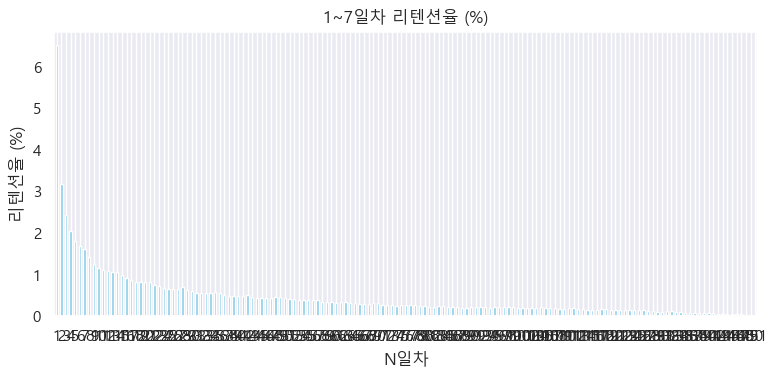

In [32]:
# 시각화
plt.figure(figsize=(8, 4))
retention_rate_1to7.plot(kind='bar', color='skyblue')
plt.title('1~7일차 리텐션율 (%)')
plt.xlabel('N일차')
plt.ylabel('리텐션율 (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 데이터프레임으로 변환 후 저장
retention_df_1to7 = retention_rate_1to7.reset_index()
retention_df_1to7.columns = ['days_since_first', 'retention_rate']

In [33]:
# CSV 저장
retention_df_1to7.to_csv('data/10_retention_rate.csv', index=False)
print("✅ retention_rate_day1_to_day7.csv 파일로 저장 완료되었습니다.")

✅ retention_rate_day1_to_day7.csv 파일로 저장 완료되었습니다.


In [39]:
# 10. 원하는 일차만 필터링
target_days = [1, 7, 30]
filtered_retention = retention_rate[retention_rate.index.isin(target_days)]

In [40]:
# 11. 출력
print(filtered_retention)

days_since_first
1     6.52
7     1.62
30    0.61
Name: user_id, dtype: float64


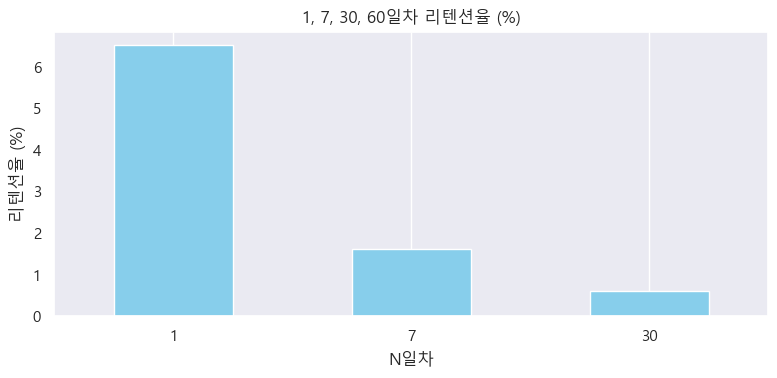

In [41]:
# 12. 시각화
plt.figure(figsize=(8, 4))
filtered_retention.plot(kind='bar', color='skyblue')
plt.title('1, 7, 30, 60일차 리텐션율 (%)')
plt.xlabel('N일차')
plt.ylabel('리텐션율 (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [42]:
# 인덱스를 컬럼으로 변환 후 저장
retention_df = filtered_retention.reset_index()
retention_df.columns = ['days_since_first', 'retention_rate']

# CSV로 저장
retention_df.to_csv('data/10_retention_rate_1_7_30.csv', index=False)